In [307]:
# Main data packages. 
import numpy as np
import pandas as pd
from datetime import datetime

import pickle

#text processing, NLP modules
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
#plotting
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [308]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [359]:
df = pd.read_csv("Data/vaccination_tweets.csv")

In [360]:
df_tweety = df.copy()

In [361]:
#Insert column 'day' to map the vaccination progress data set
df_tweety['day'] = pd.to_datetime(df_tweety.date).dt.date

## Reshape the data set

Tweets in 'text' are typically cut off (max 140 characters). The cut-off-pattern is '...', followed by an empty space and a link to the tweet. Using this pattern to reduce the dataset we receive a considerably shorter set of certainly complete tweets to analyze.

In [362]:
df_tweety = df_tweety[~(df_tweety['text'].str.contains('... http'))].reset_index()

In [363]:
df_tweety.shape

(5621, 18)

In [364]:
df_tweety.to_csv('fulltweets.csv')

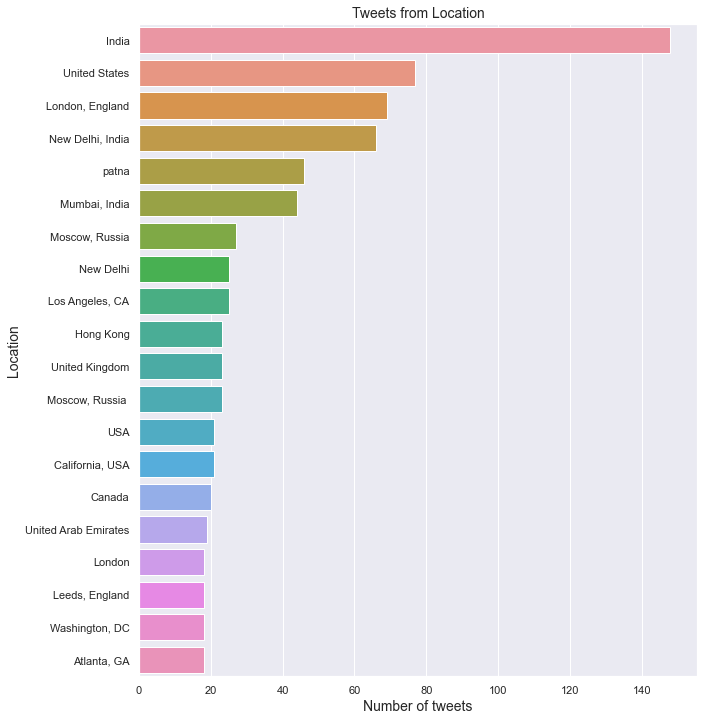

In [365]:
#user_location columns is very diverse
plt.figure(figsize=(10,12))
sns.barplot(df_tweety["user_location"].value_counts().values[0:20],
            df_tweety["user_location"].value_counts().index[0:20]);
plt.title("Tweets from Location",fontsize=14)
plt.xlabel("Number of tweets",fontsize=14)
plt.ylabel("Location",fontsize=14)
plt.show()

## User Influence

In [366]:
#new feature user influence
def user_influence(df):
    fact = 0
    if df['user_verified'] == 'True':
        fact=1.0
    else:
        fact=0.8
    influence = np.sqrt(df['user_followers']*0.35+df['user_friends']*0.15+df['user_favourites']*0.15+df['retweets']*0.35)*fact
    return np.round(influence)

df_tweety['user_infl'] = df_tweety.apply(user_influence,axis=1)

In [367]:
influence_factor = df_tweety.groupby(['user_name'])['user_infl'].mean().round().sort_values(ascending=False)
influence_factor = pd.DataFrame(influence_factor)
influence_factor['user_infl'].quantile(.99)


245.28000000000065

Lists in 'hashtags' are stored as strings

In [318]:
#for i, l in enumerate(df_tweety['hashtags']):
    #print("list",i,"is",type(l))

lst_ = "['erst', 'zweit', 'dritt']"

def clean_hashtag(name):
    name = name.replace("[", "")
    name = name.replace("]", "")
    name = name.replace("'", "")
    name_lst = name.split(",")
    hash_lst = list()
    for item in name_lst:
        item = item.strip()
        hash_lst.append(item)
    return hash_lst

In [319]:
df_tweety['hashtags'] = df_tweety['hashtags'].apply(eval)

TypeError: eval() arg 1 must be a string, bytes or code object

In [320]:
df_tweety['hashtags'] = df_tweety['hashtags'].fillna('[]')

def to_1D(Series):
    return pd.Series([x.lower() for lst in Series for x in lst])

hasht_freq = to_1D(df_tweety['hashtags']).value_counts()[:30].rename_axis('hasht_freq').reset_index(name='count')
hasht_freq

,hasht_freq,count
0,',24590
1,a,11429
2,i,10827
3,n,10434
4,c,10055
5,o,9690
6,e,9303
7,,6707
8,",",6707
9,r,6538


In [321]:
df_tweety['hashtags'] = df_tweety['hashtags'].apply(eval)

In [322]:
df_tweety['hashtags'] = df_tweety['hashtags'].fillna('[]')

def to_1D(Series):
    return pd.Series([x.lower() for lst in Series for x in lst])

hasht_freq = to_1D(df_tweety['hashtags']).value_counts()[:30].rename_axis('hasht_freq').reset_index(name='count')
hasht_freq

,hasht_freq,count
0,moderna,1935
1,covaxin,1356
2,pfizerbiontech,709
3,sputnikv,694
4,vaccine,543
5,covid19,525
6,oxfordastrazeneca,491
7,covidvaccine,354
8,pfizer,299
9,sinovac,252


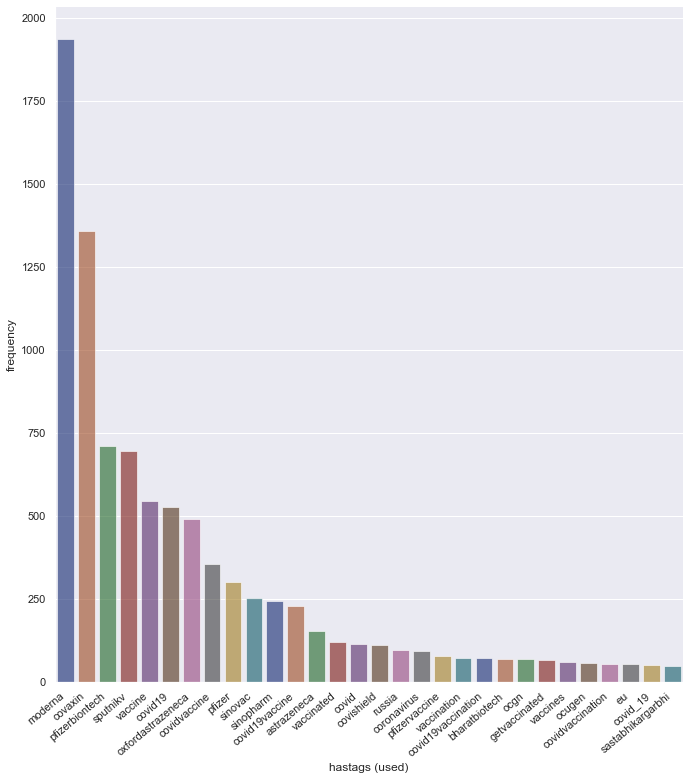

In [323]:
#f, ax = plt.subplots(figsize=(7, 5))

g = sns.catplot(
    data=hasht_freq, kind="bar",
    x="hasht_freq", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("hastags (used)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

In contrast, particular vaccines or the vaccination topic play the dominant role in the category of used hashtags. Politicians or institutions do not figure prominently in this category.

## Rank #s, append hashtag columns to dataframe

Idea: create df with vaccines in hashtags as columns and append it to df_tweety

In [324]:
def to_1D(Series):
    return pd.Series([x.lower() for lst in Series for x in lst])

unique_hasht = to_1D(df_tweety['hashtags']).value_counts()[:30]

In [325]:
def boolean_df(item_lists, unique_items):

    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask that returns a True-False list of whether a tag is in a taglist
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [326]:
hasht_bool = boolean_df(df_tweety['hashtags'], unique_hasht.keys())
#Drop non-vaccine related columns
#hasht_bool.drop(['covid19', 'covid', 'china', 'russia', 'bharatbiotech', 'eu', 'india', 'covid_19', 'coronavirus'], axis=1)

In [327]:
df_tweety_vaccs = pd.concat([df_tweety, hasht_bool], axis=1)
df_tweety_vaccs = df_tweety_vaccs.drop(['user_followers', 'user_friends', 'user_favourites', 'hashtags', 'user_verified',
       'date'], axis=1)

In [328]:
df_tweety_infl = df_tweety[df_tweety['user_infl']>245.3]
df_tweety_vaccs_infl = df_tweety_vaccs[df_tweety_vaccs['user_infl']>254.3]

# Sentiment analysis (full tweets)

## Sentiment analysis with VADER

### Cleaning, feature engineering

In [329]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['moderna', 'covaxin', 'covid19', 'pfizerbiontech', 'vaccine', 'sputnikv', 'oxfordastrazeneca', 'covidvaccine', 'pfizer', 'sinovac', 'sinopharm', 'covid19vaccine', 'astrazeneca', 'covid', 'coronavirus', 'vaccines', 'china', 'russia', 'covishield', 'vaccination', 'vaccinated', 'pfizervaccine', 'eu', 'india', 'covid_19', 'bharatbiotech', 'covidvaccination', 'covid19vaccination', 'coronavaccine', 'mrna', 'johnsonandjohnson', 'getvaccinated', 'biontech', 'narendramodi', 'hongkong', 'pakistan', 'covidvacccine', 'pmmodi', 'modernavaccine', 'ocgn', 'iran', 'nhs', 'coronavirusvaccine', 'ocugen', 'breaking', 'covidvaccines', 'aiims', 'russian', 'pfizercovidvaccine', 'vaccineswork', 'news', 'putin', 'uk', 'who', 'us', 'canada', 'italy', 'covidー19', 'covid19vaccines', 'israel', 'corona', 'hungary', 'zimbabwe', 'pandemic', 'covax', 'oxfordvaccine', 'usa', 'health', 'modi', 'vaccine', 'first', 'covid', 'dose', 'today', '19', 'vaccines', 'amp', 'shot', 'doses']
#stopwords.extend(newStopWords)

Most frequent words and topic words are added to stopwords.

In [368]:
def clean_tweet_vader(x):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    x = str(x)
    x = x.lower()

    #remove twitter handlers
    x = re.sub('@[^\s]+','',x)
    #remove hashtags
    x = re.sub('#[^\s]+','',x)
    #remove URLs
    x = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x)
    #remove punctuation
    #x = x.replace('[^\w\s]','')
    #remove single characters
    x = re.sub(r'\s+[a-zA-Z0-9]\s+', '', x)
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    #remove linebreaks
    x = re.sub('\n', '', x)
    #remove special characters
    x = ' '.join(re.findall(r'\w+', x))
    #stemming
    #x = ' '.join([stemmer.stem(word) for word in x.split() ])
    #lemmatizing
    x = ' '.join([lemmatizer.lemmatize(word) for word in x.split() ])
    #removing stop words
    x = ' '.join([word for word in x.split() if word not in stopwords])
    #removing numbers
    #x = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x)
    #x = x.split()

    return x

In [369]:
df_tweety.text = df_tweety.text.apply(lambda x: clean_tweet_vader(x))

In [370]:
#!pip install vaderSentiment

In [371]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [372]:
analyser = SentimentIntensityAnalyzer()

scores=[]
for i in range(len(df_tweety['text'])):
    
    score = analyser.polarity_scores(df_tweety['text'][i])
    score=score['compound']
    scores.append(score)
    
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('positive')
    elif i<=(-0.05):
        sentiment.append('negative')
    else:
        sentiment.append('neutral')

Add VADER qualitative sentiment values to data frames:

In [373]:
df_tweety['sentiment']=pd.Series(np.array(sentiment))
df_tweety_vaccs['sentiment']=pd.Series(np.array(sentiment))

Create corresponding data frames for the most influential 1% of users:

In [374]:
df_tweety_infl = df_tweety[df_tweety['user_infl']>192]
df_tweety_vaccs_infl = df_tweety_vaccs[df_tweety_vaccs['user_infl']>192]

### Basic statistics

Based on VADER asssignments of sentiment polarity.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


neutral    0
positive   0
negative   0
Name: sentiment, dtype: float64

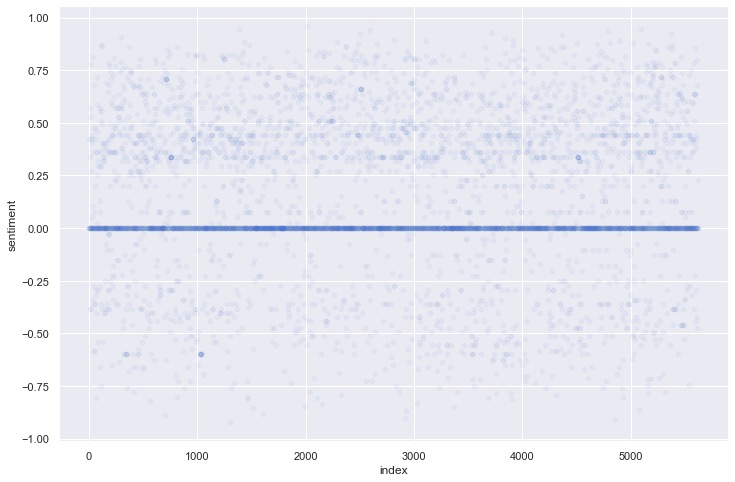

In [375]:
scores = pd.Series(np.array(scores))
df_scores = pd.DataFrame(scores).reset_index()
df_scores2 = df_scores.rename(columns={0: 'sentiment'})

df_scores2.plot.scatter(x='index', y='sentiment', alpha=0.05)
df_tweety.sentiment.value_counts()/len(df_tweety)

Count of sentiments per day

In [356]:
daily_sent = df_tweety.groupby(['day', 'sentiment'])['index'].count()
df_daily_sent = pd.DataFrame(daily_sent)#.reset_index()#.rename(columns={"index": "count"})
df_daily_sent

index
day        sentiment       
2020-12-12 negative       1
           neutral        5
           positive       1
2020-12-13 neutral        7
           positive       3
...                     ...
2021-03-25 neutral       64
           positive      38
2021-03-26 negative       4
           neutral       21
           positive       5

[290 rows x 1 columns]

# Second sentiment analysis (BLOB)

## Cleaning, feature engineering for TextBlob

In [249]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

In [250]:
def clean_tweet_blob(x):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    x = str(x)
    x = x.lower()

    #remove twitter handlers
    x = re.sub('@[^\s]+','',x)
    #remove hashtags
    x = re.sub('#[^\s]+','',x)
    #remove URLs
    x = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x)
    #remove punctuation
    x = x.replace('[^\w\s]','')
    #remove single characters
    x = re.sub(r'\s+[a-zA-Z0-9]\s+', '', x)
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    #remove linebreaks
    x = re.sub('\n', '', x)
    #remove special characters
    x = ' '.join(re.findall(r'\w+', x))
    #stemming
    x = ' '.join([stemmer.stem(word) for word in x.split() ])
    #lemmatizing
    x = ' '.join([lemmatizer.lemmatize(word) for word in x.split() ])
    #removing stop words
    x = ' '.join([word for word in x.split() if word not in stopwords])
    #removing numbers
    x = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x)
    #x = x.split()

    return x

In [251]:
df_tweety_tb = df_tweety
df_tweety_tb_vaccs = df_tweety_vaccs
df_tweety_tb.text.apply(lambda x: clean_tweet_blob(x))

0                                  covid vaccin get
1                      author unit state last night
2             immigr muslim coupl find covid vaccin
3             ladi gentleman expert everi household
4       fact sheet healthcar provid administ vaccin
                           ...                     
5616                                      crossword
5617          author seiz fake batch russian vaccin
5618       expect indian govern allow access vaccin
5619                                          go go
5620                                       mr putin
Name: text, Length: 5621, dtype: object

In [252]:
#install TextBlob, a python library for processing textual data
#!pip install textblob

#import TextBlob
from textblob import TextBlob

#from pylab import rcParams
#rcParams['figure.figsize'] = 12, 8

In [253]:
def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

In [254]:
df_tweety_tb_vaccs['subjectivity'] = df_tweety_tb_vaccs['text'].apply(getTextSubjectivity)
df_tweety_tb_vaccs['sentiment'] = df_tweety_tb_vaccs['text'].apply(getTextPolarity)

df_tweety_tb['subjectivity'] = df_tweety_tb['text'].apply(getTextSubjectivity)
df_tweety_tb['sentiment'] = df_tweety_tb['text'].apply(getTextPolarity)

In [255]:
# negative, nautral, positive analysis
def getTextAnalysis(tweet):
    if tweet >= 0.05:
        return "positive"
    elif tweet <= (-0.05):
        return "negative"
    else:
        return "neutral"

df_tweety_tb_vaccs['sentiment'] = df_tweety_tb_vaccs['sentiment'].apply(getTextAnalysis)
df_tweety_tb['sentiment'] = df_tweety_tb['sentiment'].apply(getTextAnalysis)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


neutral    1
positive   0
negative   0
Name: sentiment, dtype: float64

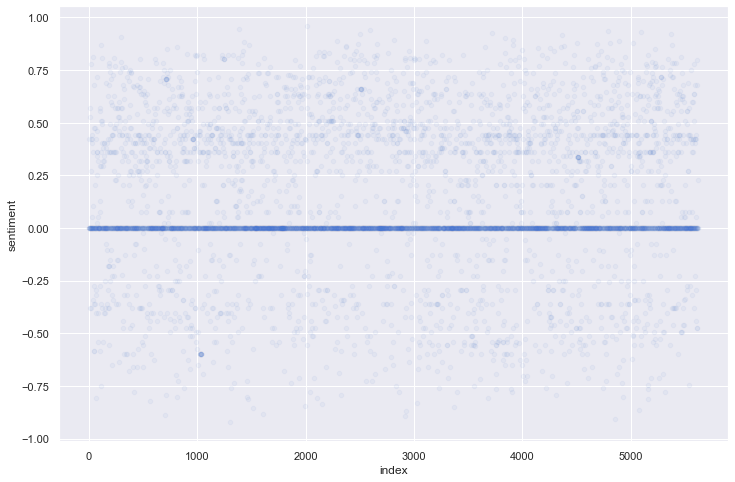

In [256]:
scores_tb = df_tweety_tb['sentiment'].tolist()#pd.Series(np.array(scores))

df_scores_tb = pd.DataFrame(scores).reset_index()
df_scores_tb = df_scores.rename(columns={0: 'sentiment'})

df_scores_tb.plot.scatter(x='index', y='sentiment', alpha=0.05)

df_tweety_tb.sentiment.value_counts()/len(df_tweety)

VADER polarity scores do not seem to be correlated with user influence.

In [257]:
df_tweety['scores'] = scores
df_tweety.sentiment.value_counts()/len(df_tweety)

import statsmodels.formula.api as smf

# mpg explained by horsepower and weight
smf.ols(formula='scores ~ user_followers + retweets + user_favourites + user_friends + favorites', data=df_tweety).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 scores   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3786
Date:                Sat, 24 Apr 2021   Prob (F-statistic):              0.864
Time:                        12:54:24   Log-Likelihood:                -1652.9
No. Observations:                5621   AIC:                             3318.
Df Residuals:                    5615   BIC:                             3358.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1043      0.005     21.704      0.000       0.095       0.114
user_followers  -8.738e-11   8.24e-09     -0.011      0.992   -1.62e-08    1.61e-08
retweets           -0.0002      0.000     -0.474      0.635      -0.001       0.001
user_favourites  1.069e-08   8.75e-08      0.122      0.903   -1.61e-07    1.82e-07
user_friends    -1.381e-06   1.12e-06     -1.233      0.218   -3.58e-06    8.15e-07
favorites        2.168e-05   7.32e-05      0.296      0.767      -0.000       0.000
==============================================================================
Omnibus:                       18.247   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.788
Skew:                           0.083   Prob(JB):                     3.06e-05
Kurtosis:                       3.247   Cond. No.                     5.89e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

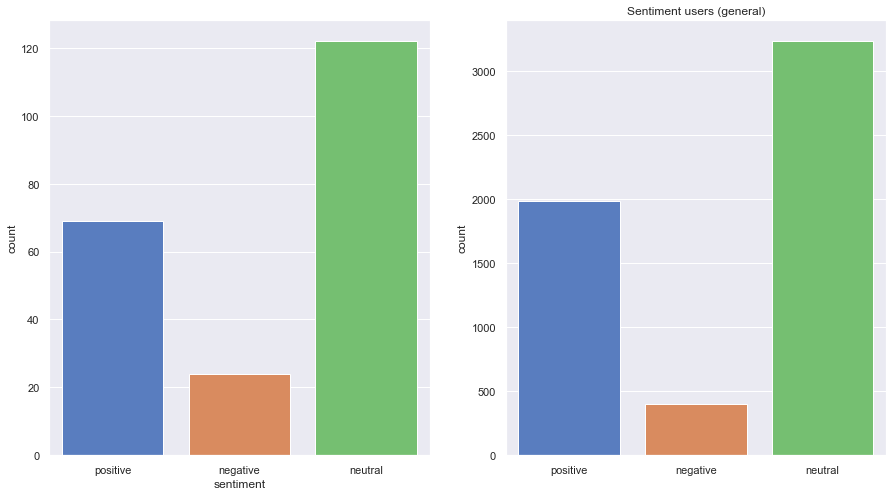

In [258]:
order_list = ['positive', 'negative', 'neutral']
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='sentiment',data=df_tweety_infl, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sentiment users (most influential 1%)')

plt.subplot(1, 2, 2)
ax = sns.countplot(x='sentiment',data=df_tweety, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sentiment users (general)')
plt.show()

Expectedly, this picture is confirmed by an investigation into the correlation between user influence and sentiment.

In [259]:
df_tweety['scores'] = scores

#import statsmodels.formula.api as smf
#smf.ols(formula='user_infl ~ C(sentiment)', data=df_tweety).fit().summary()

## Sentiments relative to vaccines (extracted from most frequent hashtags)

To track and measure the opinion towards specific vaccines, we evaluate the sentiment of tweets which use a specific vaccine-name as a hashtag and compare them with those that refer to the topic of vaccination in general. If the hashtag mentions a specific vaccine, the likelihood is higher that the sentiment of the tweet has the vaccine as its object of evaluation.

The type names are taken from the set of the most frequently mentioned hashtags.

In [260]:
#Create subframes for plotting the sentiments relative to specific vaccines
df_moderna = df_tweety_vaccs[(df_tweety_vaccs['moderna']==True)]
df_moderna1 = df_moderna[['sentiment']]

df_covaxin = df_tweety_vaccs[(df_tweety_vaccs['covaxin']==True)
                            | (df_tweety_vaccs['bharatbiotech']==True)]
df_covaxin1 = df_covaxin[['sentiment']]

df_vacc = df_tweety_vaccs[(df_tweety_vaccs['vaccine']==True) | 
                          (df_tweety_vaccs['vaccinated']==True) |
                          (df_tweety_vaccs['vaccines']==True) |
                          (df_tweety_vaccs['covidvaccination']==True)|
                          (df_tweety_vaccs['covid19vaccination']==True)]
df_vacc1 = df_vacc['sentiment']

df_sinovac = df_tweety_vaccs[(df_tweety_vaccs['sinovac']==True)]
df_sinovac1 = df_sinovac[['sinovac', 'sentiment']]

df_sinopharm = df_tweety_vaccs[(df_tweety_vaccs['sinopharm']==True)]
df_sinopharm1 = df_sinopharm[['sinopharm', 'sentiment']]

df_biontech = df_tweety_vaccs[(df_tweety_vaccs['pfizerbiontech']==True)|
                              (df_tweety_vaccs['pfizer']==True)|
                              (df_tweety_vaccs['pfizervaccine']==True)]
df_biontech1 = df_biontech[['sentiment']]

df_astrazeneca = df_tweety_vaccs[(df_tweety_vaccs['astrazeneca']==True)|
                                (df_tweety_vaccs['oxfordastrazeneca']==True)]
df_astrazeneca1 = df_astrazeneca[['sentiment']]

df_sputnik = df_tweety_vaccs[(df_tweety_vaccs['sputnikv']==True)]
df_sputnik1 = df_sputnik[['sputnikv', 'sentiment']]

[Text(0.5, 0, ''), Text(0, 0.5, 'count'), Text(0.5, 1.0, 'covaxin')]

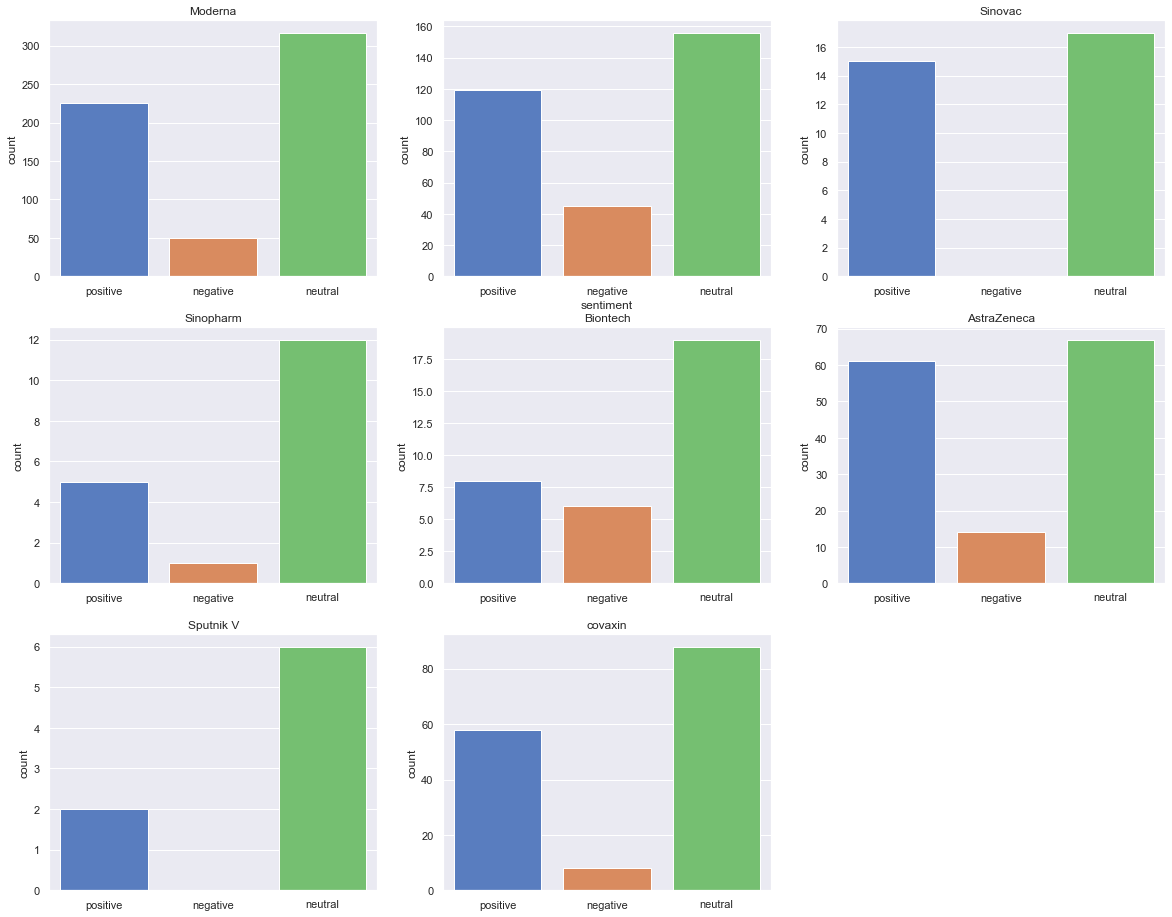

In [261]:
order_list = ['positive', 'negative', 'neutral']

plt.figure(figsize = (20, 16))

plt.subplot(3, 3, 1)
ax = sns.countplot(x='sentiment',data=df_vacc, order = order_list)
ax.set(xlabel='', ylabel='count', title='Vaccine')
plt.subplot(3, 3, 2)
sns.countplot(x='sentiment',data=df_moderna, order = order_list)
ax.set(xlabel='', ylabel='count', title='Moderna')
plt.subplot(3, 3, 3)
ax = sns.countplot(x='sentiment',data=df_sinovac, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sinovac')

plt.subplot(3, 3, 4)
ax = sns.countplot(x='sentiment',data=df_sinopharm, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sinopharm')
plt.subplot(3, 3, 5)
ax = sns.countplot(x='sentiment',data=df_biontech, order = order_list)
ax.set(xlabel='', ylabel='count', title='Biontech')
plt.subplot(3, 3, 6)
ax = sns.countplot(x='sentiment',data=df_astrazeneca, order = order_list)
ax.set(xlabel='', ylabel='count', title='AstraZeneca')

plt.subplot(3, 3, 7)
ax = sns.countplot(x='sentiment',data=df_sputnik, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sputnik V')
plt.subplot(3, 3, 8)
ax = sns.countplot(x='sentiment',data=df_covaxin, order = order_list)
ax.set(xlabel='', ylabel='count', title='covaxin')

## Sentiments by influence

### The most influential sources

News sources from India and China and Indian individuals make up the larger part of the top influential users. The sentiments conveyed by their messages are of particular interest. The ranking is almost identical with to the follower ranking.

<AxesSubplot:xlabel='user_followers', ylabel='user_name'>

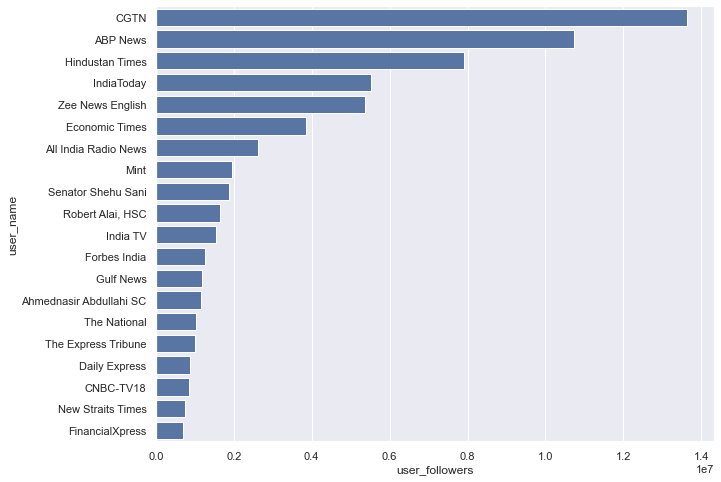

In [262]:
twinfluence1 = df_tweety.sort_values("user_infl", ascending=False).reset_index(drop=True)
twinfluence1 = twinfluence1.drop_duplicates(subset=['user_name'], keep='last')
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='user_followers', y='user_name', orient='h', color='b', data=twinfluence1[['user_name', 'user_followers']][:20])

In [170]:
#Create subframes for plotting the sentiments relative to specific vaccines
df_modernA = df_tweety_vaccs_infl[(df_tweety_vaccs_infl['moderna']==True)]
df_modernA1 = df_moderna[['moderna', 'sentiment']]

df_covaxiN = df_tweety_vaccs[(df_tweety_vaccs['covaxin']==True)
                            | (df_tweety_vaccs['bharatbiotech']==True)]
df_covaxiN1 = df_covaxin[['sentiment']]

df_vacC = df_tweety_vaccs_infl[(df_tweety_vaccs_infl['vaccine']==True) | 
                          (df_tweety_vaccs_infl['vaccinated']==True) |
                          (df_tweety_vaccs_infl['vaccines']==True) |
                          (df_tweety_vaccs_infl['covidvaccination']==True)|
                          (df_tweety_vaccs_infl['covid19vaccination']==True)]
df_vacC1 = df_vacc['sentiment']

df_sinovaC = df_tweety_vaccs_infl[(df_tweety_vaccs_infl['sinovac']==True)]
df_sinovaC1 = df_sinovac[['sinovac', 'sentiment']]

df_sinopharM = df_tweety_vaccs_infl[(df_tweety_vaccs_infl['sinopharm']==True)]
df_sinopharM1 = df_sinopharm[['sinopharm', 'sentiment']]

df_biontecH = df_tweety_vaccs_infl[(df_tweety_vaccs_infl['pfizerbiontech']==True)|
                              (df_tweety_vaccs_infl['pfizer']==True)|
                              (df_tweety_vaccs_infl['pfizervaccine']==True)]
df_biontecH1 = df_biontech[['sentiment']]

df_astrazenecA = df_tweety_vaccs_infl[(df_tweety_vaccs_infl['astrazeneca']==True)|
                                (df_tweety_vaccs_infl['oxfordastrazeneca']==True)]
df_astrazenecA1 = df_astrazeneca[['sentiment']]

df_sputniK = df_tweety_vaccs_infl[(df_tweety_vaccs_infl['sputnikv']==True)]
df_sputniK1 = df_sputnik[['sputnikv', 'sentiment']]

### Sentiment by news source

[Text(0.5, 0, ''),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'The Express Tribune')]

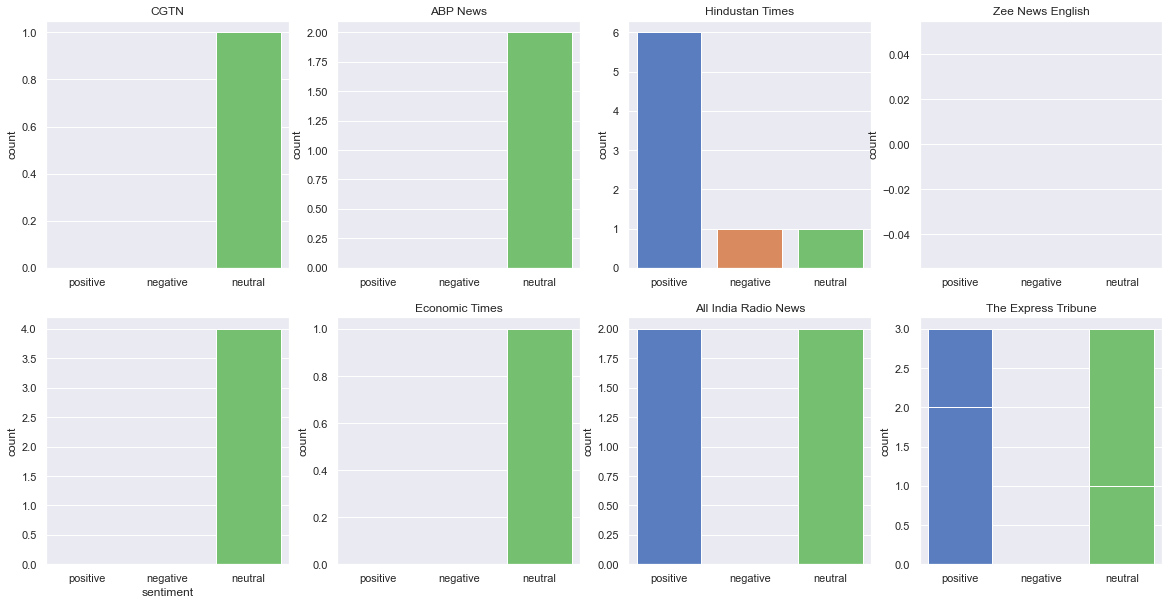

In [264]:
NDTV = df_tweety[df_tweety['user_name']=='CGTN']
ABP = df_tweety[df_tweety['user_name']=='ABP News']
HT = df_tweety[df_tweety['user_name']=='Hindustan Times']
IT = df_tweety[df_tweety['user_name']=='India Today']
ZNE = df_tweety[df_tweety['user_name']=='Zee News English']
ET = df_tweety[df_tweety['user_name']=='Economic Times']
AIRN = df_tweety[df_tweety['user_name']=='All India Radio News']
MINT = df_tweety[df_tweety['user_name']=='Mint']
ITV = df_tweety[df_tweety['user_name']=='India TV']
GN = df_tweety[df_tweety['user_name']=='Gulf News']
TET = df_tweety[df_tweety['user_name']=='The Express Tribune']



order_list = ['positive', 'negative', 'neutral']

plt.figure(figsize = (20, 10))

plt.subplot(2, 4, 1)
ax = sns.countplot(x='sentiment',data=CGTN, order = order_list)
ax.set(xlabel='', ylabel='count', title='CGTN')

plt.subplot(2, 4, 2)
ax = sns.countplot(x='sentiment',data=ABP, order = order_list)
ax.set(xlabel='', ylabel='count', title='ABP News')

plt.subplot(2, 4, 3)
ax = sns.countplot(x='sentiment',data=HT, order = order_list)
ax.set(xlabel='', ylabel='count', title='Hindustan Times')


plt.subplot(2, 4, 4)
ax = sns.countplot(x='sentiment',data=IT, order = order_list)
ax.set(xlabel='', ylabel='count', title='India Today')

plt.subplot(2, 4, 5)
sns.countplot(x='sentiment',data=ZNE, order = order_list)
ax.set(xlabel='', ylabel='count', title='Zee News English')

plt.subplot(2, 4, 6)
ax = sns.countplot(x='sentiment',data=ET, order = order_list)
ax.set(xlabel='', ylabel='count', title='Economic Times')

plt.subplot(2, 4, 7)
ax = sns.countplot(x='sentiment',data=AIRN, order = order_list)
ax.set(xlabel='', ylabel='count', title='All India Radio News')

plt.subplot(2, 4, 8)
ax = sns.countplot(x='sentiment',data=MINT, order = order_list)
ax.set(xlabel='', ylabel='count', title='Mint')

plt.subplot(2, 4, 8)
ax = sns.countplot(x='sentiment',data=ITV, order = order_list)
ax.set(xlabel='', ylabel='count', title='India TV')

plt.subplot(2, 4, 8)
ax = sns.countplot(x='sentiment',data=GN, order = order_list)
ax.set(xlabel='', ylabel='count', title='Gulf News')

plt.subplot(2, 4, 8)
ax = sns.countplot(x='sentiment',data=TET, order = order_list)
ax.set(xlabel='', ylabel='count', title='The Express Tribune')

### Top retweeted retweeted tweets for sentiments

The general sentiment proportions are slightly shifted for the popularity measure of most retweeted tweets. Looking at the top 10, positive have a slight edge over netural ones.

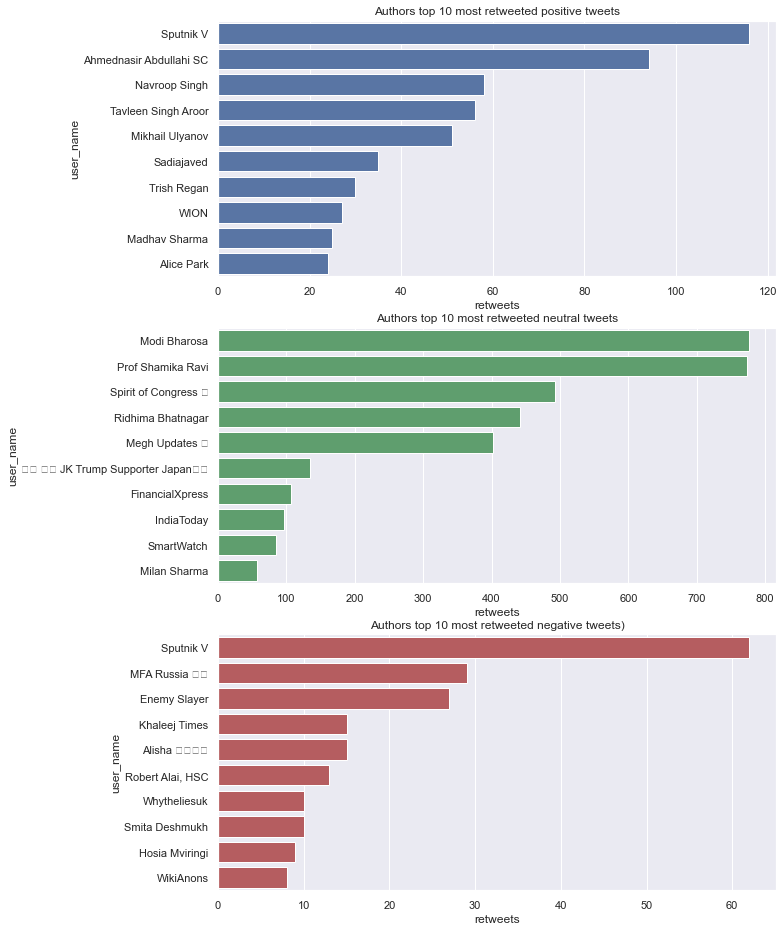

In [265]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 16))
sns.barplot(x="retweets", y="user_name", ax=ax1, palette=["b"],
            data=df_tweety[(df_tweety.sentiment== "positive")].drop_duplicates(subset=["user_name"])
            .sort_values(by=["retweets"], ascending=False)[["user_name", "retweets"]][:10])
ax1.set_title('Authors top 10 most retweeted positive tweets')

sns.barplot(x="retweets", y="user_name", ax=ax2, palette=["g"],
            data=df_tweety[(df_tweety.sentiment == "neutral")].drop_duplicates(subset=["user_name"])
            .sort_values(by=["retweets"], ascending=False)[["user_name", "retweets"]][:10])
ax2.set_title('Authors top 10 most retweeted neutral tweets')

sns.barplot(x="retweets", y="user_name", ax=ax3, palette=["r"],
           data=df_tweety[(df_tweety.sentiment == "negative")].drop_duplicates(subset=["user_name"])
           .sort_values(by=["retweets"], ascending=False)[["user_name", "retweets"]][:10])
ax3.set_title('Authors top 10 most retweeted negative tweets)')

fig.show()

### Create joint dataframe for vaccination progress and sentiments over time

In [266]:
#df_tweety = pd.concat([df_tweety, pd.get_dummies(df_tweety['sentiment'], drop_first=False, prefix='v')], axis=1)

tweety_wide = pd.pivot_table(df_tweety, index='day', columns='sentiment', values='user_created', aggfunc=pd.Series.nunique)

tweety_flat = pd.DataFrame(tweety_wide.to_records()).drop([0, 102, 103]).reset_index()

global_vacc = pd.read_csv('Data/df_global.csv')

global_vacc_senti = global_vacc.drop([12]).reset_index(drop=True)

global_vacc_senti[['negative', 'neutral', 'positive']] = tweety_flat[['negative', 'neutral', 'positive']]

In [267]:
global_vacc_senti.to_csv('Data/global_vacc_senti2.csv')

# Tweet over time, sentiment conponents

<AxesSubplot:xlabel='day'>

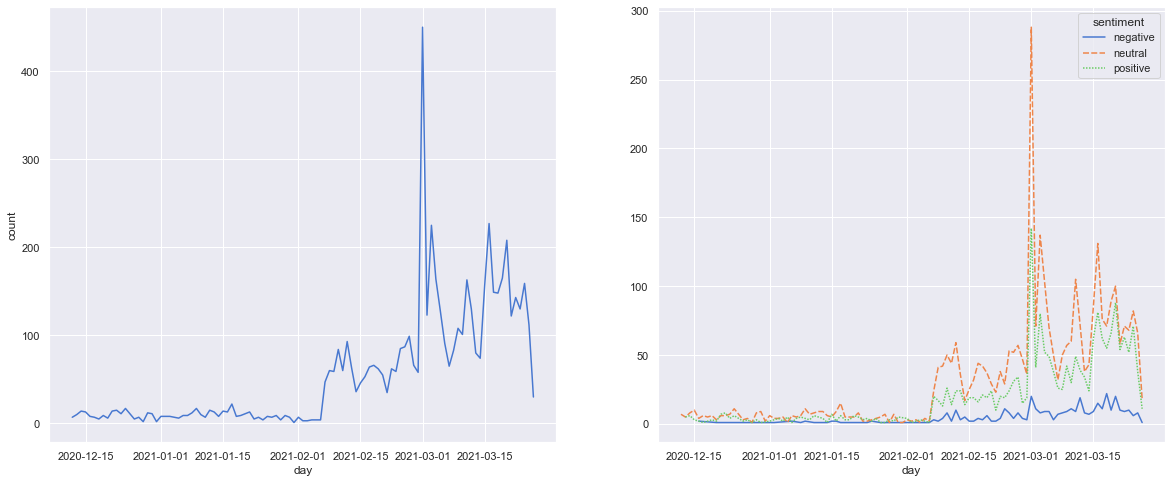

In [268]:
over_days = df_tweety.groupby(['day'])['index'].count().reset_index()
over_days.columns = ['day', 'count']

tweety_wide = pd.pivot_table(df_tweety, index='day', columns='sentiment', values='index', aggfunc=pd.Series.nunique)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)

plt.subplot(1, 2, 1)
sns.lineplot(x="day", y="count",
             data=over_days)

plt.subplot(1, 2, 2)
sns.lineplot(data=tweety_wide)

<AxesSubplot:xlabel='day'>

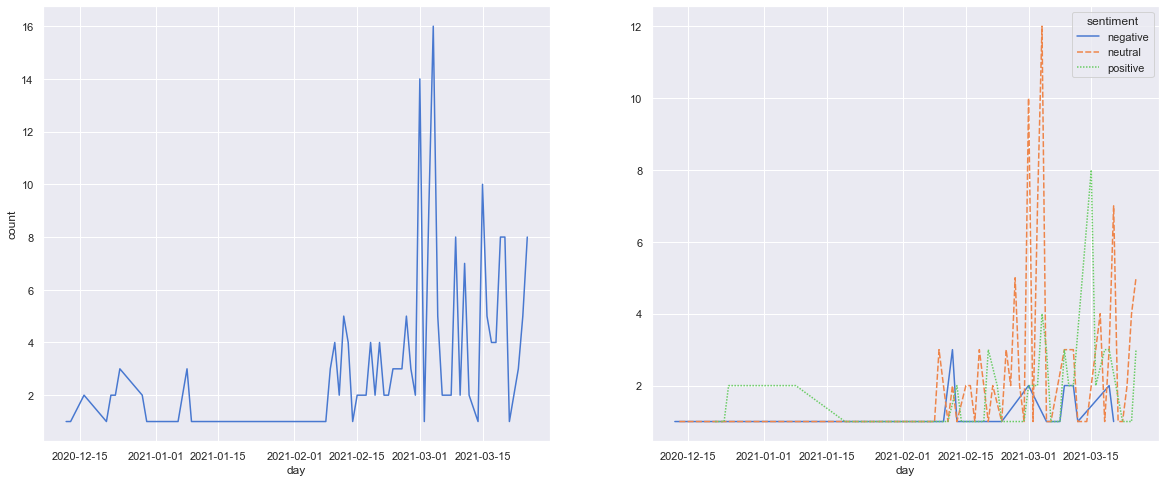

In [271]:
over_days = df_tweety_infl.groupby(['day'])['index'].count().reset_index()
over_days.columns = ['day', 'count']

tweety_wide = pd.pivot_table(df_tweety_infl, index='day', columns='sentiment', values='index', aggfunc=pd.Series.nunique)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)

plt.subplot(1, 2, 1)
sns.lineplot(x="day", y="count",
             data=over_days)

plt.subplot(1, 2, 2)
sns.lineplot(data=tweety_wide)

What happened on the first of march, in mid-february and in mid-march?

## Vaccines

### Moderna

<AxesSubplot:xlabel='day'>

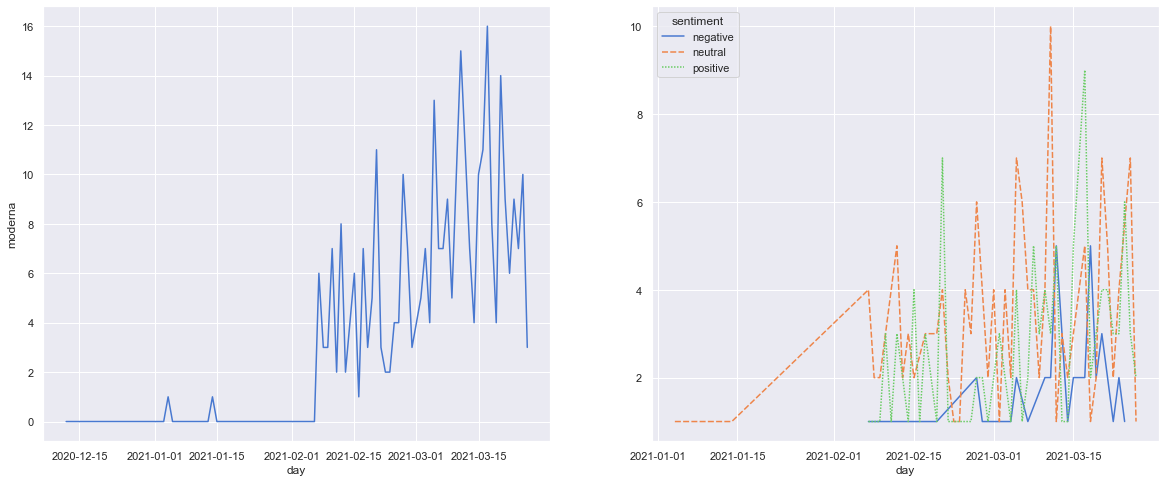

In [269]:
moderna1 = df_tweety_vaccs.groupby(['day'])['moderna'].sum()#, index='day', columns=['sentiment'], values='index', aggfunc=pd.Series.nunique)
moderna1 = pd.DataFrame(moderna1).reset_index()

moderna2 = pd.pivot_table(df_moderna, index='day', columns='sentiment', values='index', aggfunc=pd.Series.nunique)

plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
sns.lineplot(x="day", y="moderna", data=moderna1)

plt.subplot(1, 2, 2)
sns.lineplot(data=moderna2)

### Covaxin

<AxesSubplot:xlabel='day'>

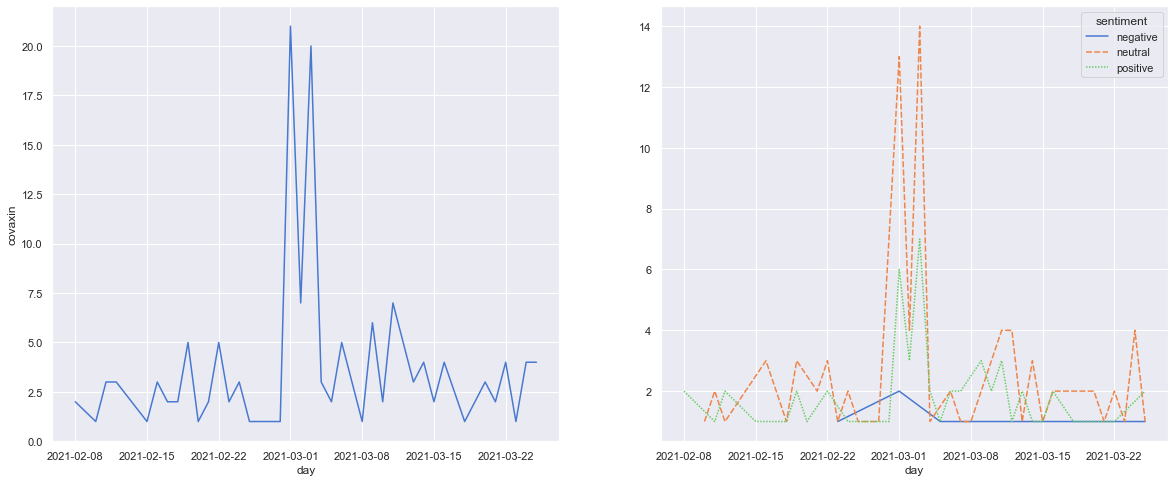

In [270]:
covaxin1 = df_covaxin.groupby(['day'])['covaxin'].sum()#, index='day', columns=['sentiment'], values='index', aggfunc=pd.Series.nunique)
covaxin1 = pd.DataFrame(covaxin1).reset_index()

covaxin2 = pd.pivot_table(df_covaxin, index='day', columns='sentiment', values='index', aggfunc=pd.Series.nunique)

plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
sns.lineplot(x="day", y="covaxin", data=covaxin1)

plt.subplot(1, 2, 2)
sns.lineplot(data=covaxin2)

### AstraZeneca

<AxesSubplot:xlabel='day'>

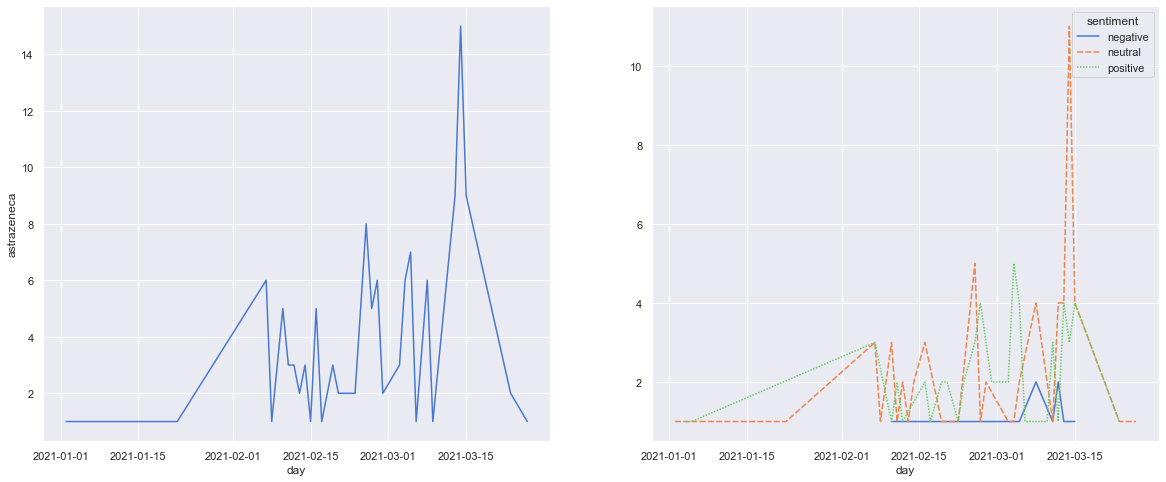

In [176]:
astrazeneca1 = df_astrazeneca.groupby(['day'])['astrazeneca'].count()#, index='day', columns=['sentiment'], values='index', aggfunc=pd.Series.nunique)
astrazeneca1 = pd.DataFrame(astrazeneca1).reset_index()

astrazeneca = pd.pivot_table(df_astrazeneca, index='day', columns='sentiment', values='index', aggfunc=pd.Series.nunique)

plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
sns.lineplot(x="day", y="astrazeneca", data=astrazeneca1)

plt.subplot(1, 2, 2)
sns.lineplot(data=astrazeneca)

What happened on the first of march, in mid-february and in mid-march?

# VADER evaluation

In [205]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [206]:
#!pip install pandas_ml

## Import and prepare manually labeled tweets

In [339]:
df_full_label = pd.read_csv('Data/full_labeled.csv', sep=';')
df_labels = df_full_label.copy()

In [340]:
df_tweety['label'] = df_labels['sentiment']

## Create data frame to validate VADER sentiment analysis against labelled tweets

In [341]:
df_test = df_tweety[0:1001]

In [342]:
df_test

,index,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,...,text,hashtags,source,retweets,favorites,is_retweet,day,user_infl,sentiment,label
0,8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,...,covid vaccine getting,"[CovidVaccine, covid19, PfizerBioNTech, Moderna]",Twitter Web App,2,1,False,2020-12-12,36,neutral,neutral
1,32,1337744008500703232,Contagion,"Cranbury, NJ",Providing timely news to improve the diagnosis...,2016-01-29 15:54:55,5998,815,5867,False,...,authorized united states last night,"[ICYMI, FDA, PfizerBioNTech, COVID19, Vaccine]",TweetDeck,0,1,False,2020-12-12,45,positive,neutral
2,35,1337739607857917954,Shahjhan Malik | #WearAMask,"Nottinghamshire, England",Solicitor.Dual Qualified.Single Parent Of 2 Am...,2017-06-22 06:22:55,41708,2868,47862,False,...,immigrant muslim couple find covid vaccine,"[CovidVaccine, PfizerBioNTech, Pfizervaccine, ...",Twitter for iPhone,2,37,False,2020-12-12,119,neutral,neutral
3,37,1337734069816348673,Farooq Anees,"دبي, الامارات العربية المتحدة",Somethings are better not be disclosed.... \o/,2010-12-23 11:51:01,293,319,165,False,...,ladies gentlemen experts every household,"[CovidVaccine, Pakistan, PfizerBioNTech, oxfor...",Twitter for Android,0,0,False,2020-12-12,11,neutral,neutral
4,38,1337733927885303808,KHuntson,USA🇺🇸,"RN, health educator, writer, researcher, wife,...",2014-01-31 01:25:24,2035,1672,6734,False,...,fact sheet healthcare providers administering ...,"[PfizerBioNTech, CovidVaccine]",Twitter Web App,0,0,False,2020-12-12,36,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,8824,1360970003332300800,Hrushikesha Mohanty,ରହୁରହୁ ହାଇଦରବାଦିଆ,ପ୍ରକୃତ ବାଲେଶ୍ୱର ଜିଲା ବଂଗାଳପୁର,2011-06-12 19:52:56,1591,77,7400,False,...,seen covaxin trending twitter let give scienti...,"[JayVigyan, Covaxin]",Twitter Web App,0,8,False,2021-02-14,33,positive,positive
997,8828,1360921103112282120,Revati,Kerala,Painting my world... WIP,2009-09-23 13:59:24,4200,656,27914,False,...,got clarifications,[Covaxin],Twitter for Android,2,10,False,2021-02-14,61,neutral,negative
998,8834,1361241650824171521,WAM English,UAE,The official Twitter feed for Emirates News Ag...,2014-09-04 10:22:21,42764,18,11,True,...,approves russia vaccine use,"[Kazakhstan, SputnikV, WamNews]",Twitter Web App,0,1,False,2021-02-15,98,positive,neutral
999,8850,1361185592327872517,Sikreto,NaN,NaN,2020-12-15 00:05:33,1,2,0,False,...,muslims world spy criminals worldwide,"[SputnikV, ShameonyouChina, ChinaSetupFirewall...",Twitter for Android,0,0,False,2021-02-15,1,negative,negative


In [343]:
df_test.label.value_counts()/len(df_test)

neutral    1
positive   0
negative   0
Name: label, dtype: float64

In [344]:
df_test.sentiment.value_counts()/len(df_test)

neutral    0
positive   0
negative   0
Name: sentiment, dtype: float64

## Compare VADER estimates to labels

Comparing VADER on the full dataset (all tweets) and the subset (full tweets) gives a similar distribution of positive, neutral and negative values.

Comparing VADER predictions and labels on the subset, the labels tend towards neutrality at the expense of negative tweets. More tweets than in VADER's prediction come out as neutral.

In [376]:
#change values from strings to numbers
booleans = {'negative': -1, 'positive': 1, 'neutral': 0}
df_test['label'] = df_test['label'].map(booleans)
df_test['sentiment'] = df_test['sentiment'].map(booleans)

df_test.to_csv('Data/tweety_test.csv', index=False)

In [377]:
#transform series to arrays for evaluation
y_test = np.array(df_test['label'])
y_pred = np.array(df_test['sentiment'])
y_test = y_test.astype(float)
pd.options.display.float_format = '{:,.0f}'.format

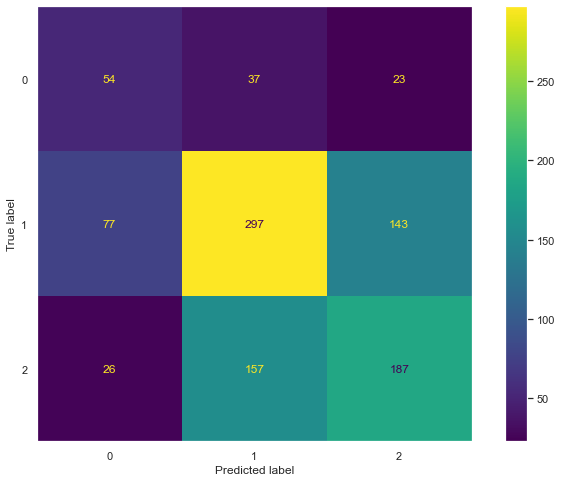

Confusion Matrix

[[ 54  37  23]
 [ 77 297 143]
 [ 26 157 187]]

Accuracy: 0.54

Micro Precision: 0.54
Micro Recall: 0.54
Micro F1-score: 0.54

Macro Precision: 0.49
Macro Recall: 0.52
Macro F1-score: 0.50

Weighted Precision: 0.55
Weighted Recall: 0.54
Weighted F1-score: 0.54

Classification Report

              precision    recall  f1-score   support

     Class 1       0.34      0.47      0.40       114
     Class 2       0.60      0.57      0.59       517
     Class 3       0.53      0.51      0.52       370

    accuracy                           0.54      1001
   macro avg       0.49      0.52      0.50      1001
weighted avg       0.55      0.54      0.54      1001



In [358]:
confusion = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=None)
disp = disp.plot(include_values=True)
plt.grid(False)
plt.show()

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

In [378]:
#with additional stopwords, without stemming, lemmatization

confusion = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=None)
disp = disp.plot(include_values=True)
plt.grid(False)
plt.show()

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Second sentiment analysis (BLOB)

In [220]:
# TextBlob - Python library for processing textual data
from textblob import TextBlob

# Matplotlib - plotting library to create graphs and charts
import matplotlib.pyplot as plt

# Settings for Matplotlib graphs and charts
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [221]:
#!pip install textblob

In [222]:
df = pd.read_csv('fulltweets.csv')
df_tweety2 = df.copy()

In [223]:
df_tweety_vaccs2 = pd.concat([df_tweety2, hasht_bool], axis=1)
df_tweety_vaccs2 = df_tweety_vaccs2.drop(['id', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'hashtags', 'user_verified', 'source', 'is_retweet',
       'date'], axis=1)

In [224]:
def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

In [225]:
df_tweety_vaccs2['subjectivity'] = df_tweety_vaccs2['text'].apply(getTextSubjectivity)
df_tweety_vaccs2['sentiment'] = df_tweety_vaccs2['text'].apply(getTextPolarity)

df_tweety2['subjectivity'] = df_tweety2['text'].apply(getTextSubjectivity)
df_tweety2['sentiment'] = df_tweety2['text'].apply(getTextPolarity)

In [226]:
# negative, nautral, positive analysis
def getTextAnalysis(tweet):
    if tweet >= 0.05:
        return "positive"
    elif tweet <= (-0.05):
        return "negative"
    else:
        return "neutral"

In [227]:
df_tweety_vaccs2['sentiment'] = df_tweety_vaccs2['sentiment'].apply(getTextAnalysis)
df_tweety2['sentiment'] = df_tweety2['sentiment'].apply(getTextAnalysis)

In [228]:
df_tweety2['label'] = df_labels['sentiment']

In [229]:
df_blobtest = df_tweety2[0:1000]

In [230]:
booleans = {'negative': 0, 'positive': 1, 'neutral': 2}

df_blobtest['label'] = df_blobtest['label'].map(booleans)
df_blobtest['sentiment'] = df_blobtest['sentiment'].map(booleans)

In [234]:
y_test = np.array(df_blobtest['label'])
y_pred = np.array(df_blobtest['sentiment'])
y_test = y_test.astype(float)
pd.options.display.float_format = '{:,.0f}'.format

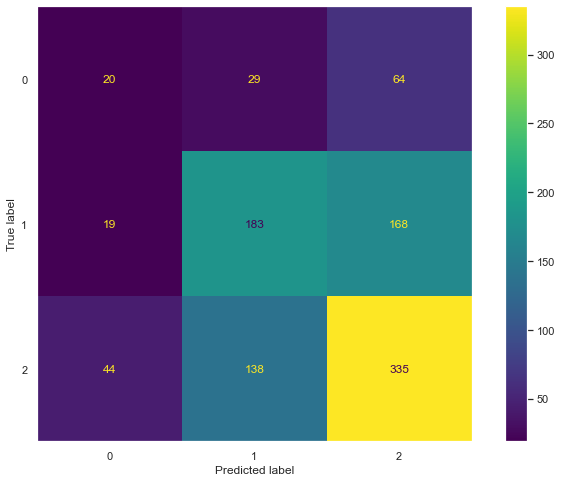

Confusion Matrix

[[ 20  29  64]
 [ 19 183 168]
 [ 44 138 335]]

Accuracy: 0.54

Micro Precision: 0.54
Micro Recall: 0.54
Micro F1-score: 0.54

Macro Precision: 0.45
Macro Recall: 0.44
Macro F1-score: 0.44

Weighted Precision: 0.53
Weighted Recall: 0.54
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.24      0.18      0.20       113
     Class 2       0.52      0.49      0.51       370
     Class 3       0.59      0.65      0.62       517

    accuracy                           0.54      1000
   macro avg       0.45      0.44      0.44      1000
weighted avg       0.53      0.54      0.53      1000



In [235]:
confusion = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=None)
disp = disp.plot(include_values=True)
plt.grid(False)
plt.show()

print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))